In [50]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

: 

: 

In [51]:
#generate data

x_s = np.linspace(-4,4, 10)
y_s = np.linspace(-4,4, 10)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


1500

In [52]:
env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(1000):
    state = env.reset()
    X.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X.append(next_state)


X = np.array(X)


In [53]:
X = np.vstack([X, X_grid])
np.random.shuffle(X)

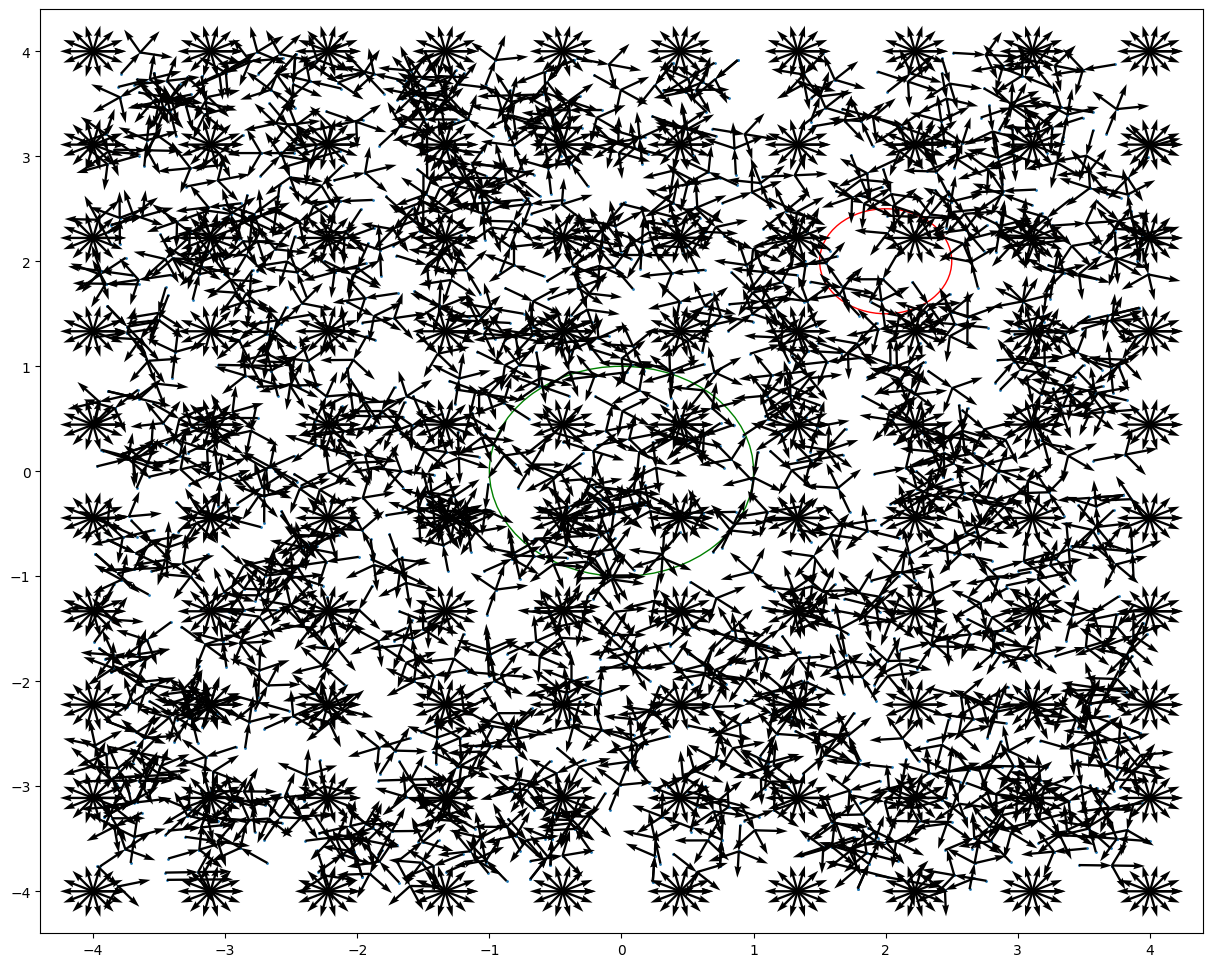

In [54]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

# Plot...
plt.scatter(X[:,0], X[:,1], s=1) # s is a size of marker 
        # draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X[:,2])
arrow_dy = arrow_len * np.sin(X[:,2])
plt.quiver(X[:,0], X[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color='k')


plt.jet()
#plt.show()
plt.savefig('env.png')

In [55]:
X

array([[-2.2222223 , -2.2222223 ,  4.9367886 ],
       [ 0.50506234,  3.740657  ,  2.6519682 ],
       [-0.1278431 , -0.16204157,  3.892184  ],
       ...,
       [-1.4731038 , -0.31468904,  5.71112   ],
       [-3.1366665 , -3.2787855 ,  3.756261  ],
       [ 3.1302972 , -1.7463716 ,  1.4296018 ]], dtype=float32)

In [56]:
jax.local_device_count()

1

In [57]:
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X


array([[-2.2222223 , -2.2222223 ,  0.22252104, -0.9749279 ],
       [ 0.50506234,  3.740657  , -0.8825096 ,  0.47029448],
       [-0.1278431 , -0.16204157, -0.7312857 , -0.6820713 ],
       ...,
       [-1.4731038 , -0.31468904,  0.8407847 , -0.54136956],
       [-3.1366665 , -3.2787855 , -0.8169647 , -0.5766877 ],
       [ 3.1302972 , -1.7463716 ,  0.14072587,  0.9900486 ]],
      dtype=float32)

In [60]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse



optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.9)
    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 13.008883
epoch 1 average loss 13.002471
epoch 2 average loss 12.987228
epoch 3 average loss 12.981006
epoch 4 average loss 12.965968
epoch 5 average loss 12.959989
epoch 6 average loss 12.945195
epoch 7 average loss 12.939433
epoch 8 average loss 12.924872
epoch 9 average loss 12.9193
epoch 10 average loss 12.904962
epoch 11 average loss 12.899598
epoch 12 average loss 12.885501
epoch 13 average loss 12.880283
epoch 14 average loss 12.866371
epoch 15 average loss 12.861343
epoch 16 average loss 12.847634
epoch 17 average loss 12.842747
epoch 18 average loss 12.829191
epoch 19 average loss 12.82444
epoch 20 average loss 12.81106
epoch 21 average loss 12.806467
epoch 22 average loss 12.793299
epoch 23 average loss 12.788866
epoch 24 average loss 12.775827
epoch 25 average loss 12.771512
epoch 26 average loss 12.758644
epoch 27 average loss 12.754441
epoch 28 average loss 12.741732
epoch 29 average loss 12.7376585
epoch 30 average loss 12.725114
epoch 31 average loss

KeyboardInterrupt: 

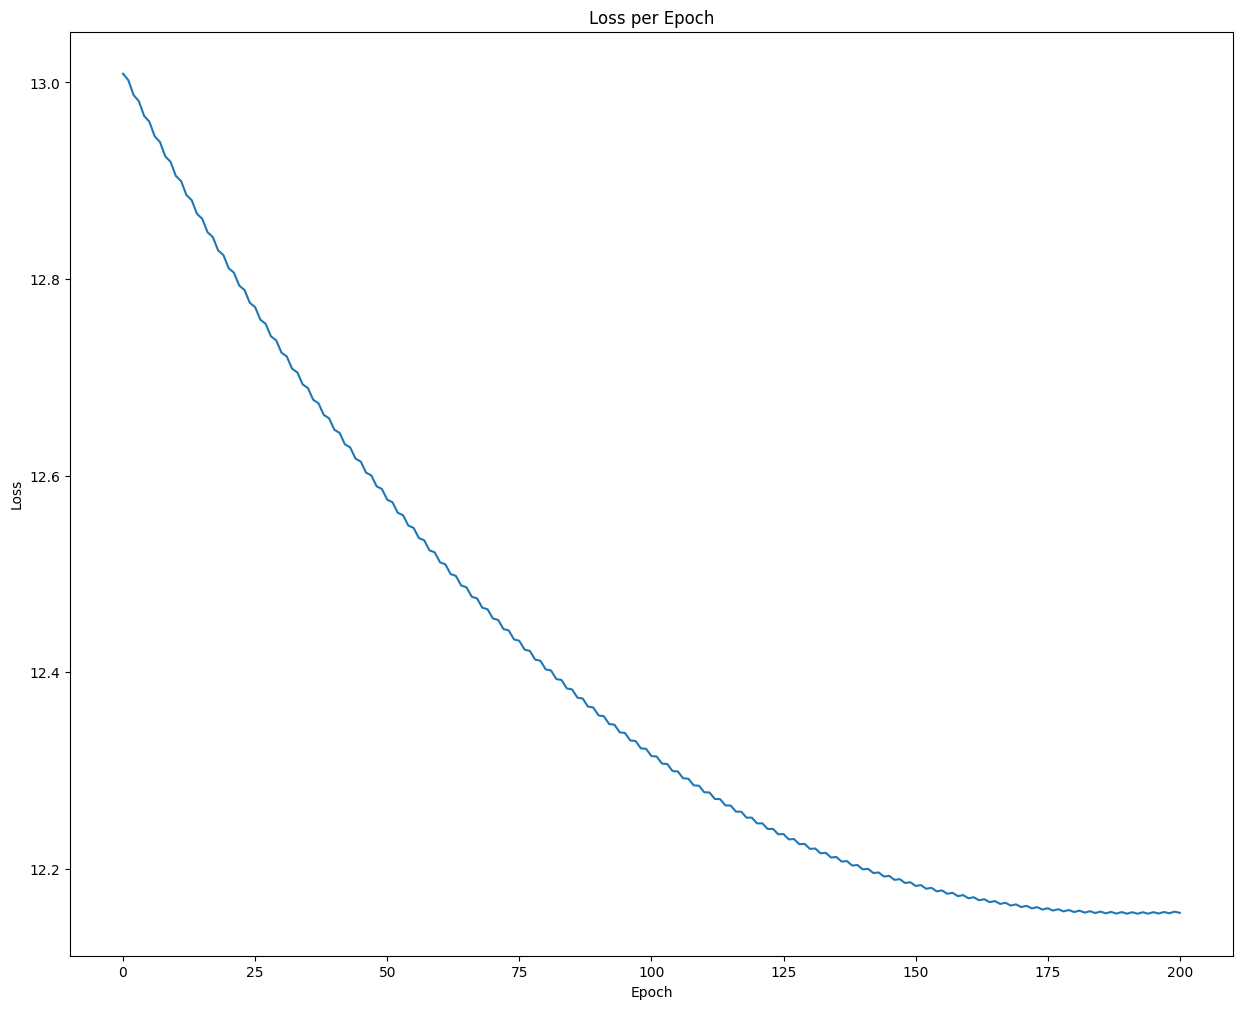

In [61]:
# Plot the losses
lo = [l.item() for l in losses]

plt.plot(lo)

# Add a title and labels to the x and y axis
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
#plt.savefig('losses.png')

plt.show()

In [62]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(1000):
    state = env.reset()
    X_val.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X_val.append(next_state)


X_val = np.array(X_val)
X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))


In [63]:
#generate data

x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_val = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(len(grid_val)):
    state = env.set(grid_val[i][0], grid_val[i][1], grid_val[i][2])
    X_val.append(state)

X_val = np.array(X_val)

X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))


In [64]:
y_pred = [forward(X=x, params=params) for x in X_val_encoded]

In [65]:
max(y_pred)

Array([0.7496978], dtype=float32)

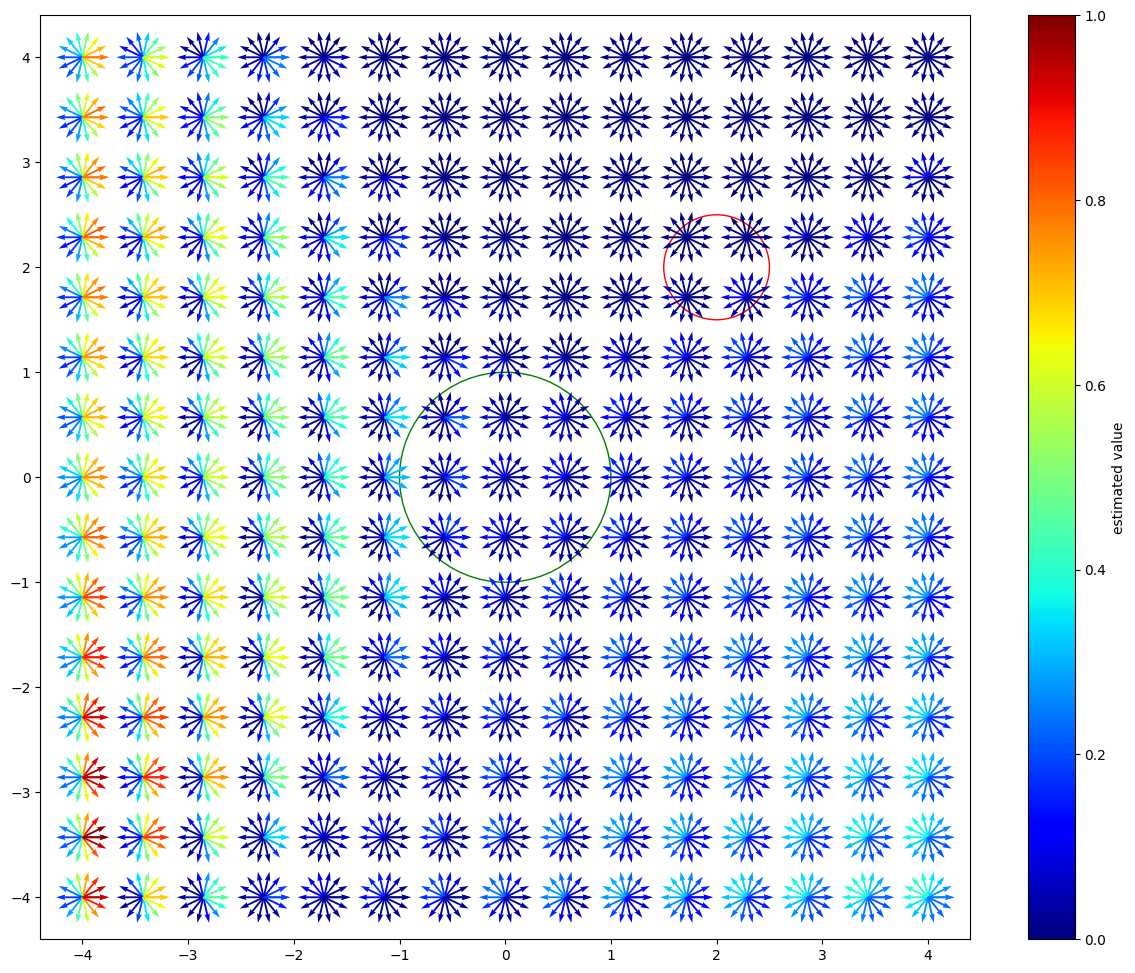

In [66]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


# Plot...
plt.scatter(X_val[:,0], X_val[:,1], s=1) # s is a size of marker 
plt.jet()
plt.colorbar(label='estimated value')
#plt.savefig('500_iter_adabeleif_.85gamma.png')
#plt.show()

#draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X_val[:,2])
arrow_dy = arrow_len * np.sin(X_val[:,2])

arrow_colors = cm.jet(y_pred/np.max(y_pred))


plt.quiver(X_val[:,0], X_val[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


plt.jet()

#plt.savefig('500_iter_adabeleif_.85gamma_grid.png')


In [67]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(-0, 4, right)
#state = env.reset()

gamma = 0.85
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    print('next_states', action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

estimate -0.04970676
state: [0.25     4.       5.148721]
estimate -0.10443732
state: [0.25 4.   0.  ]
estimate -0.131324
state: [0.25     4.       1.134464]
next_states 0 [Array(-0.04970676, dtype=float32), Array(-0.10443732, dtype=float32), Array(-0.131324, dtype=float32)]
1
estimate -0.026173173
state: [0.35565454 3.773423   4.0142574 ]
estimate -0.047489468
state: [0.35565454 3.773423   5.148721  ]
estimate -0.10149555
state: [0.35565454 3.773423   6.283185  ]
next_states 0 [Array(-0.02617317, dtype=float32), Array(-0.04748947, dtype=float32), Array(-0.10149555, dtype=float32)]
2
estimate -0.054437134
state: [0.19495766 3.5819118  2.8797934 ]
estimate -0.016484661
state: [0.19495766 3.5819118  4.0142574 ]
estimate -0.037839726
state: [0.19495766 3.5819118  5.148721  ]
next_states 1 [Array(-0.05443713, dtype=float32), Array(-0.01648466, dtype=float32), Array(-0.03783973, dtype=float32)]
3
estimate -0.0449952
state: [0.03426078 3.3904006  2.8797934 ]
estimate -0.006796162
state: [0.03

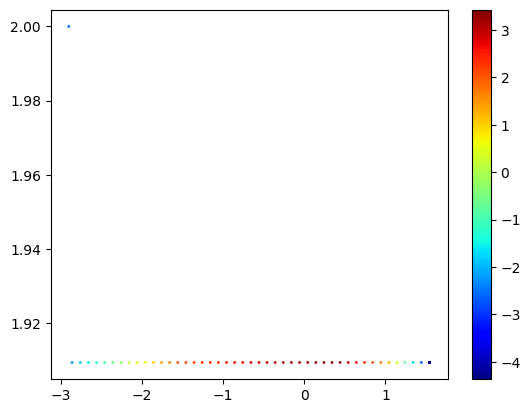

: 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([3,3,0, 0]), params=params) 

Array([-2.9606214], dtype=float32)

: 

In [ ]:
forward(X=np.array([3,3,1, 1]), params=params) 

Array([-2.536736], dtype=float32)

: 

In [ ]:
#plot with arrows and try without obstacle. 

: 